In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msn
from ydata_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
%matplotlib inline

In [2]:
df = pd.read_csv('Credit_card.csv')

In [3]:
y = pd.read_csv('Credit_card_label.csv')

In [4]:
df = df.merge(y, on='Ind_ID')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ind_ID           1548 non-null   int64  
 1   GENDER           1541 non-null   object 
 2   Car_Owner        1548 non-null   object 
 3   Propert_Owner    1548 non-null   object 
 4   CHILDREN         1548 non-null   int64  
 5   Annual_income    1525 non-null   float64
 6   Type_Income      1548 non-null   object 
 7   EDUCATION        1548 non-null   object 
 8   Marital_status   1548 non-null   object 
 9   Housing_type     1548 non-null   object 
 10  Birthday_count   1526 non-null   float64
 11  Employed_days    1548 non-null   int64  
 12  Mobile_phone     1548 non-null   int64  
 13  Work_Phone       1548 non-null   int64  
 14  Phone            1548 non-null   int64  
 15  EMAIL_ID         1548 non-null   int64  
 16  Type_Occupation  1060 non-null   object 
 17  Family_Members

<AxesSubplot:>

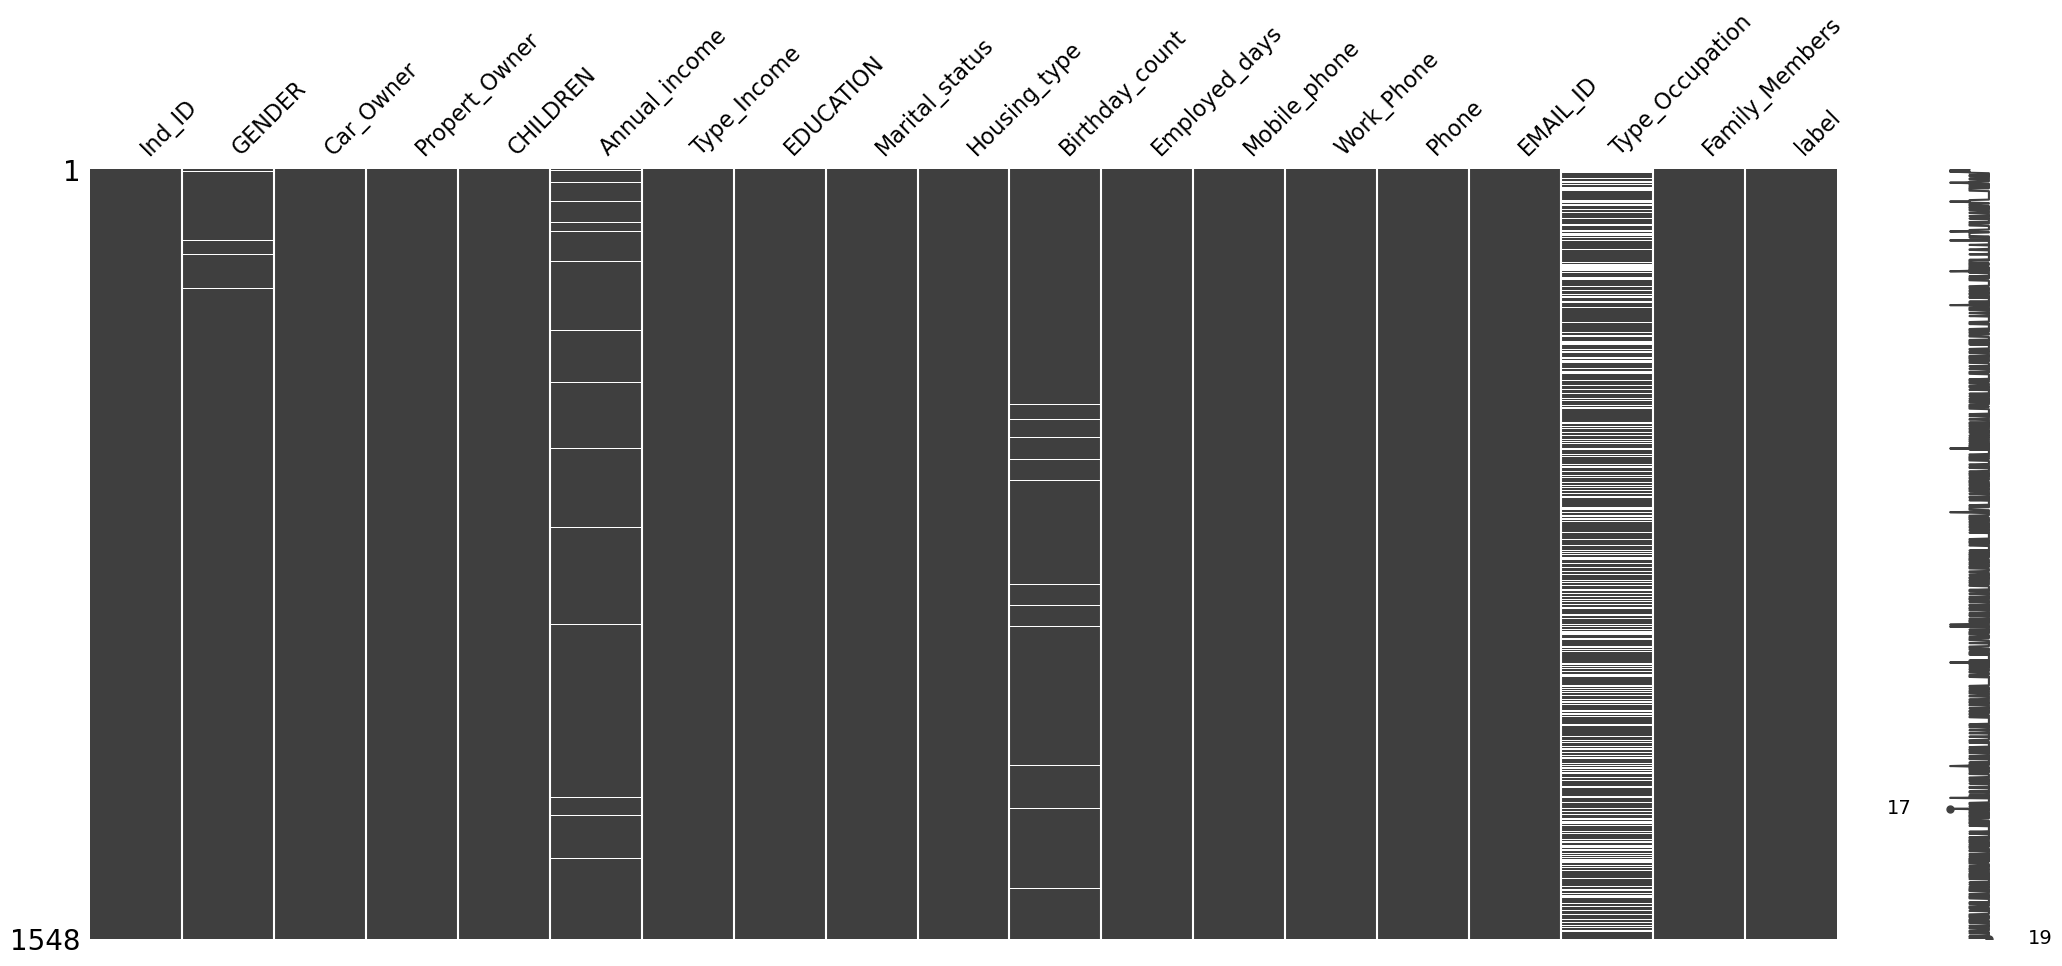

In [6]:
msn.matrix(df)

In [7]:
profile = ProfileReport(df, title='Credit cards')

In [8]:
profile.to_file('credit_cards.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
df.drop(columns=['Ind_ID', 'Mobile_phone'], inplace=True)

In [10]:
df.columns = [col.lower() for col in df.columns]

## Checking which columns have outliers and handling them

In [11]:
def check_outliers(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == np.float64 or dataframe[col].dtype == np.int64:
            plt.figure(figsize=(12,10))
            plt.title(f'Outliers in {col}')
            sns.boxplot(y = dataframe[col])
            plt.show()

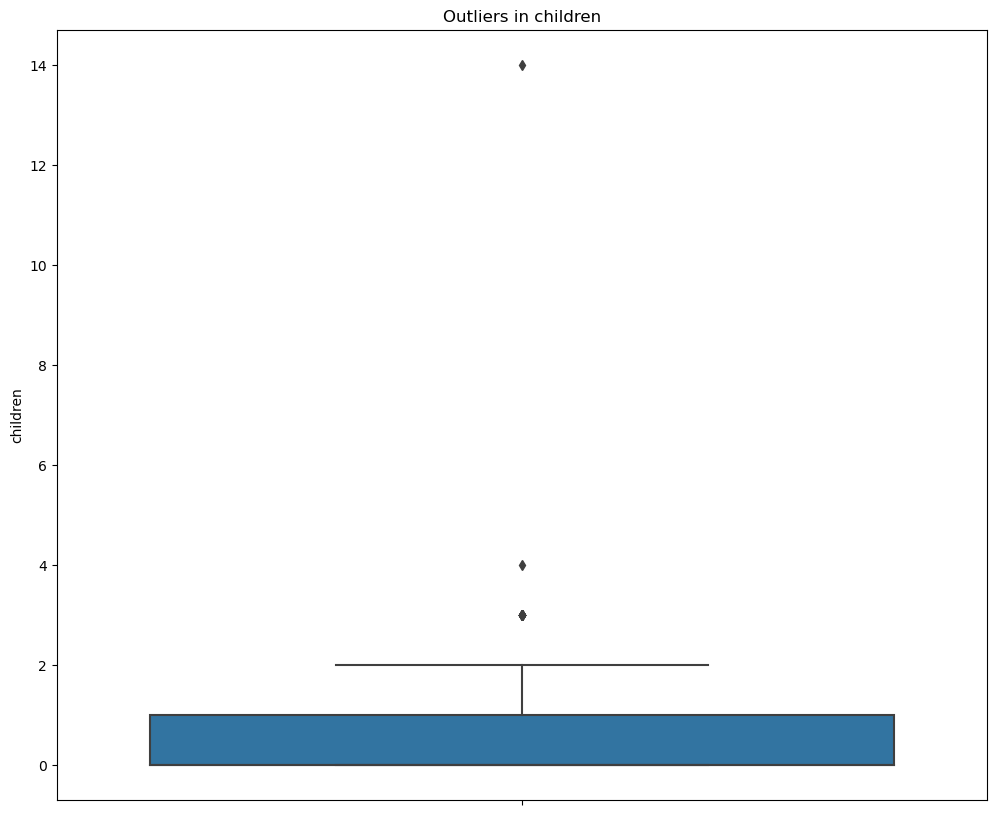

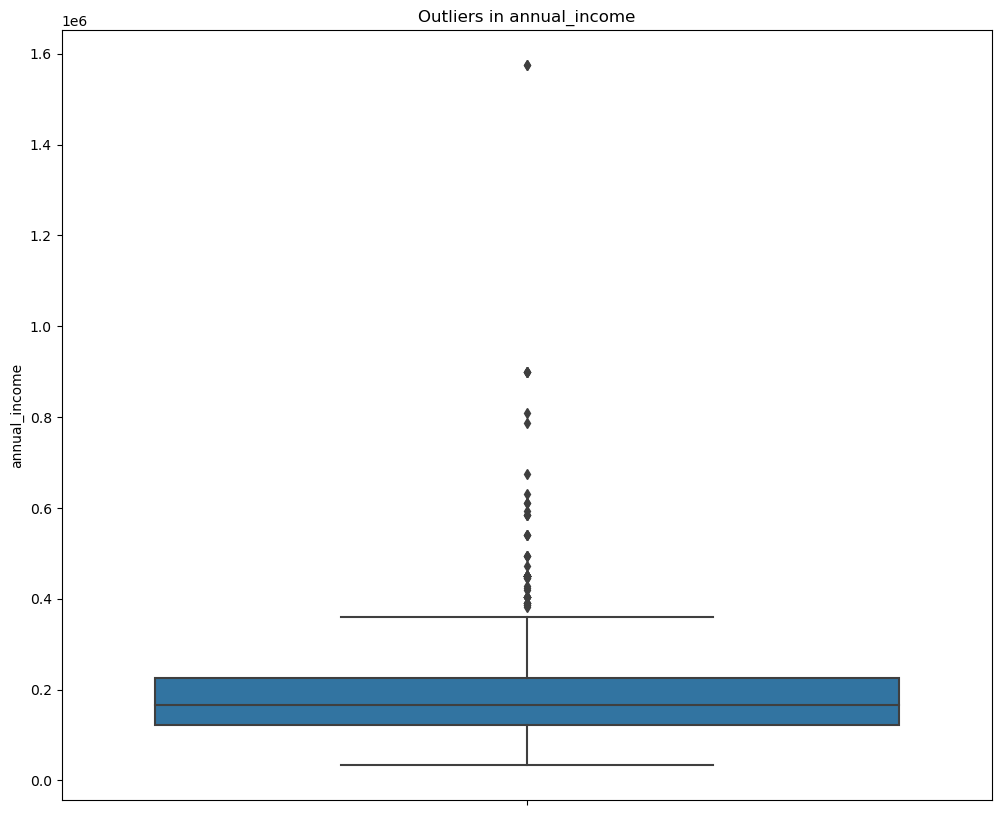

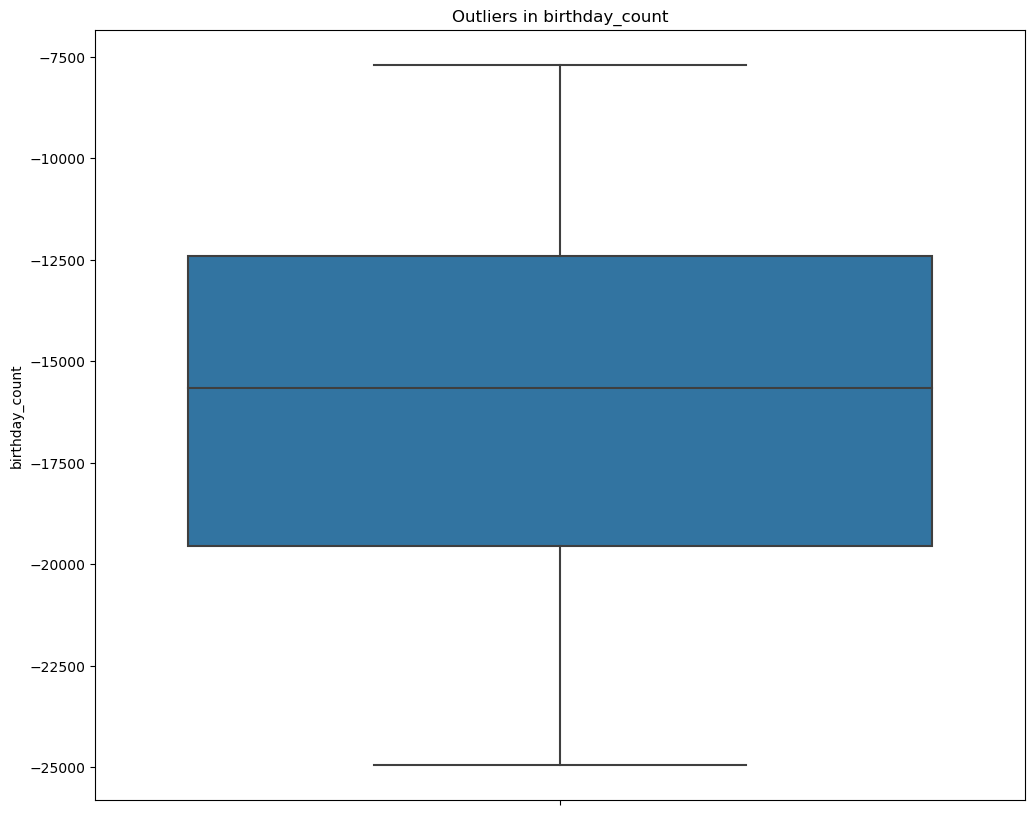

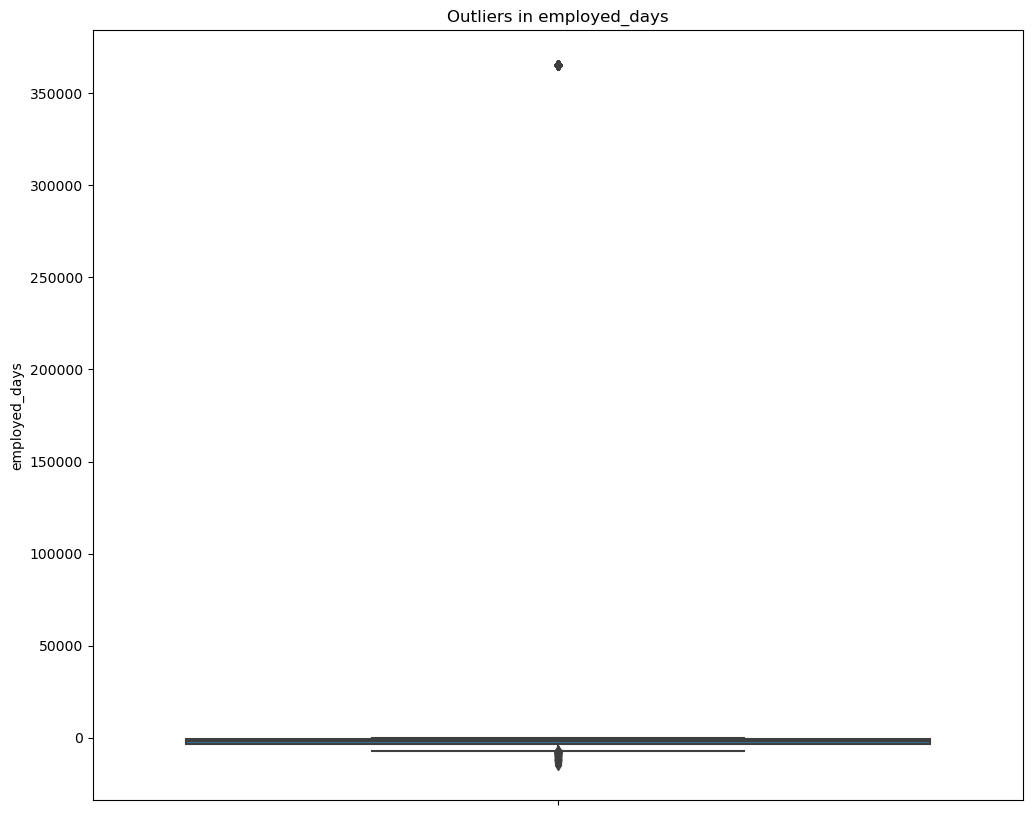

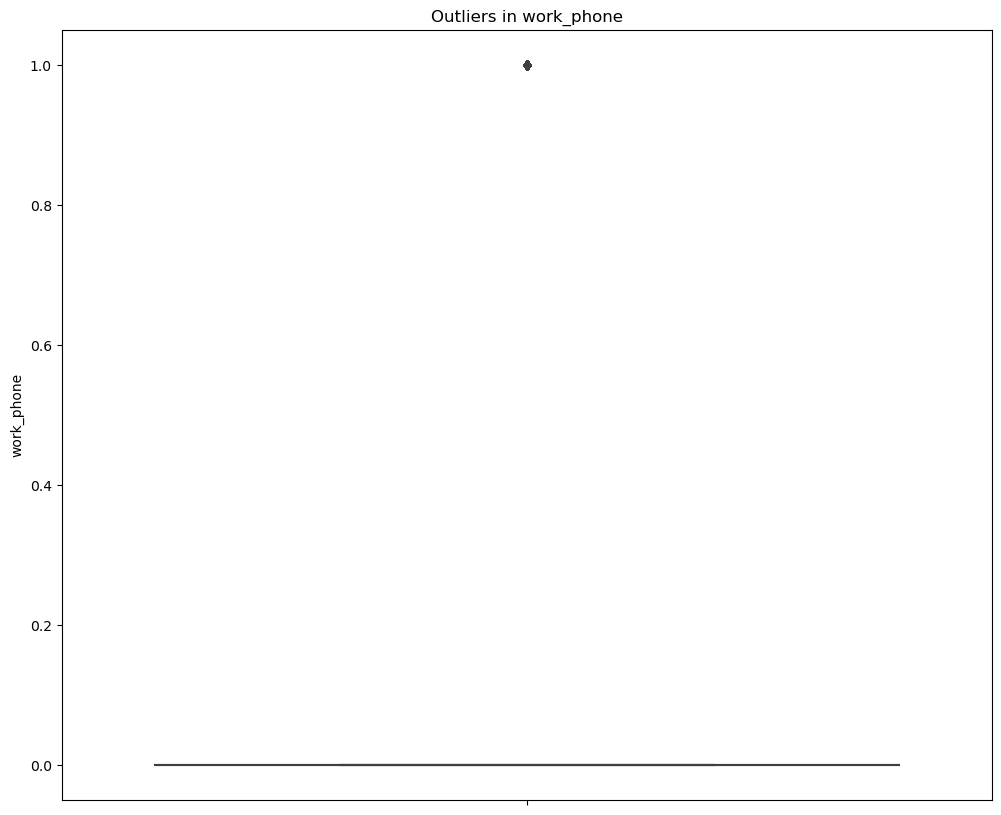

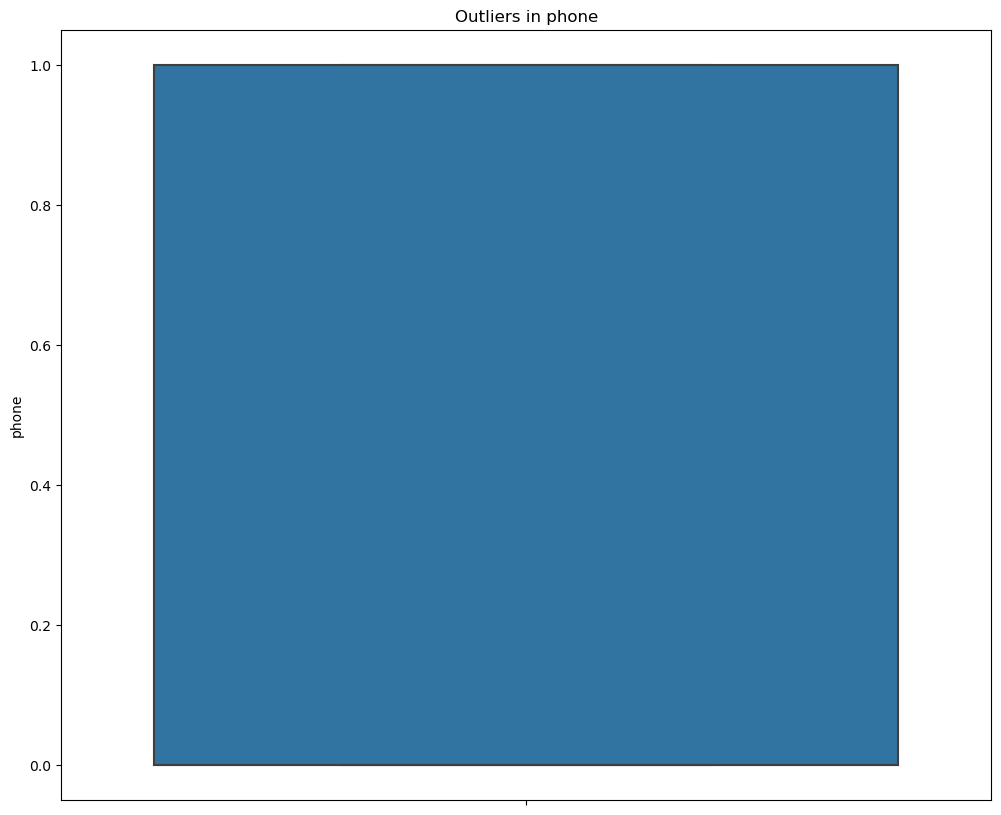

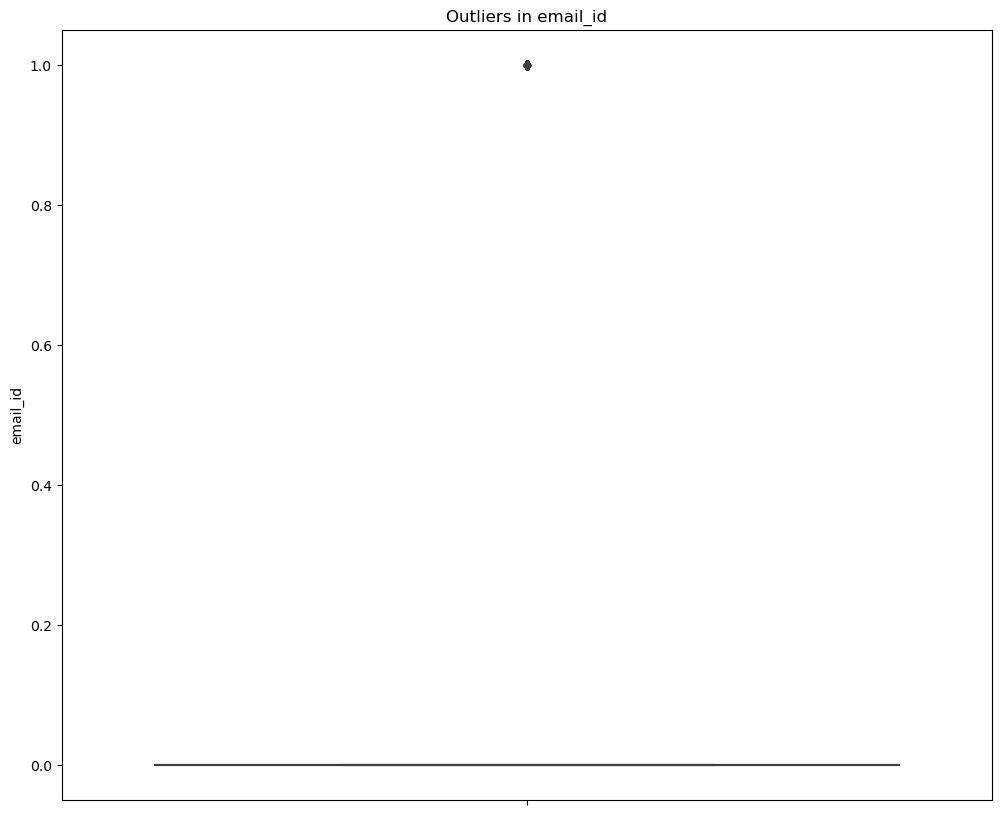

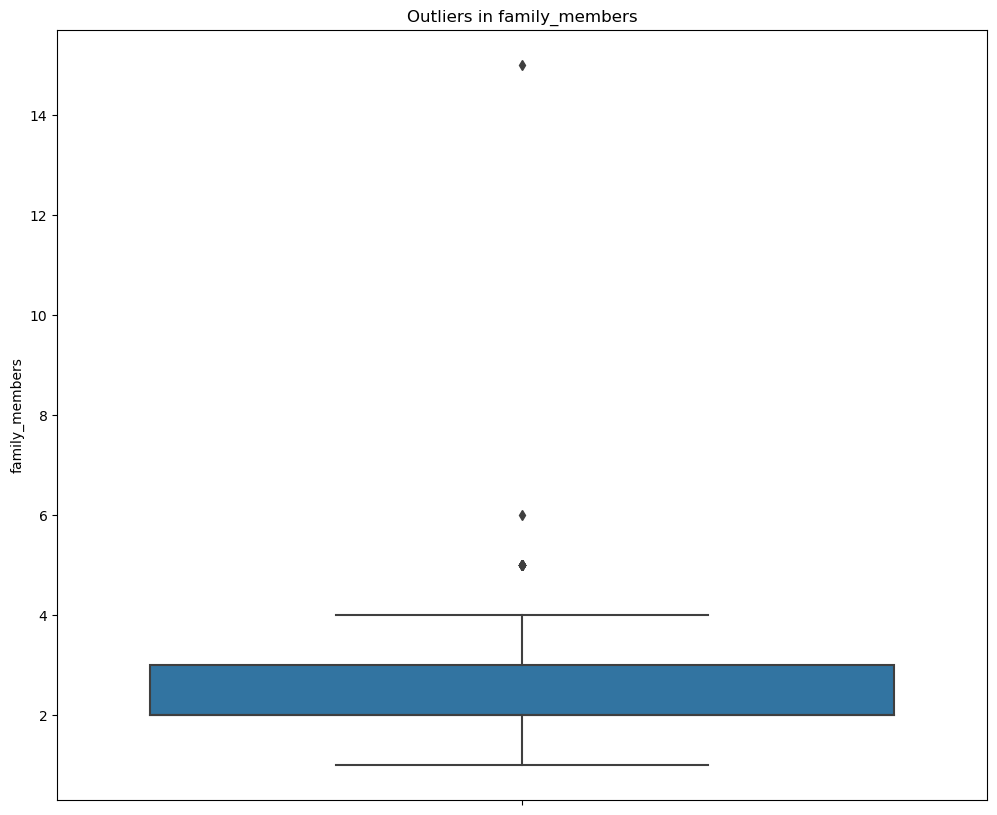

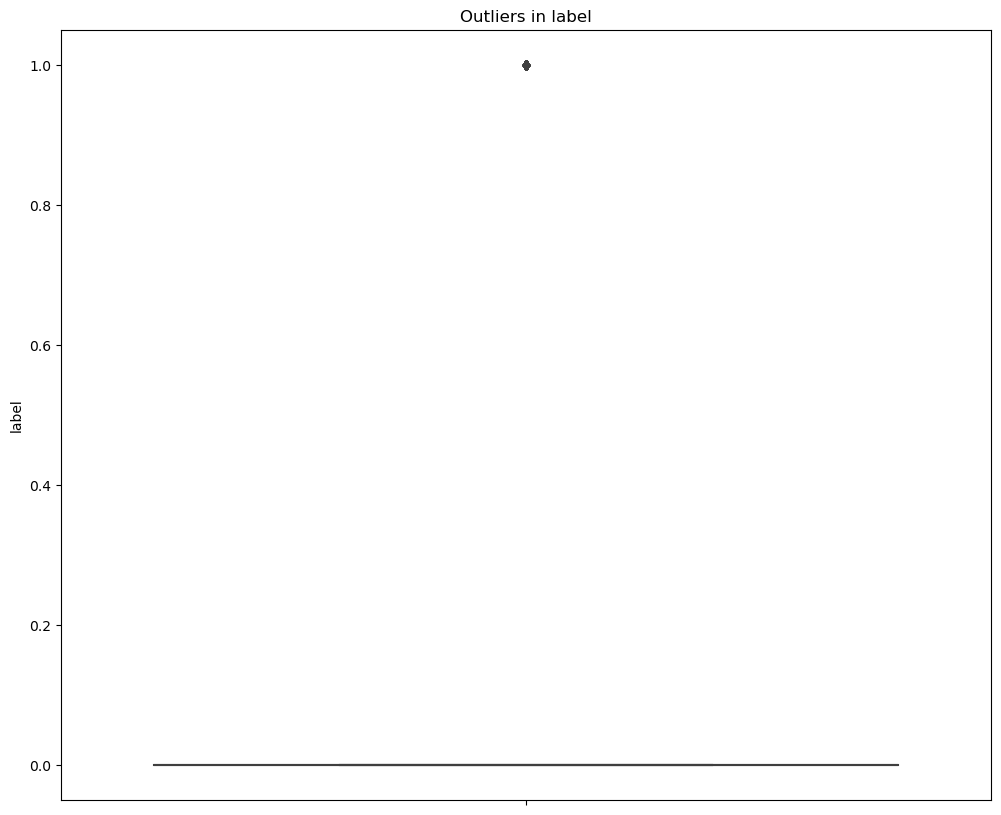

In [12]:
check_outliers(df)

In [13]:
def remove_outliers(dataframe, columns = 'list'):
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        
        low_limit = Q1 - (1.5*IQR)
        up_limit = Q3 + (1.5*IQR)
        
        dataframe.loc[dataframe[col] < low_limit, col] = low_limit
        dataframe.loc[dataframe[col] > up_limit, col] = up_limit
    return dataframe

In [14]:
df = remove_outliers(df, ['annual_income', 'employed_days'])

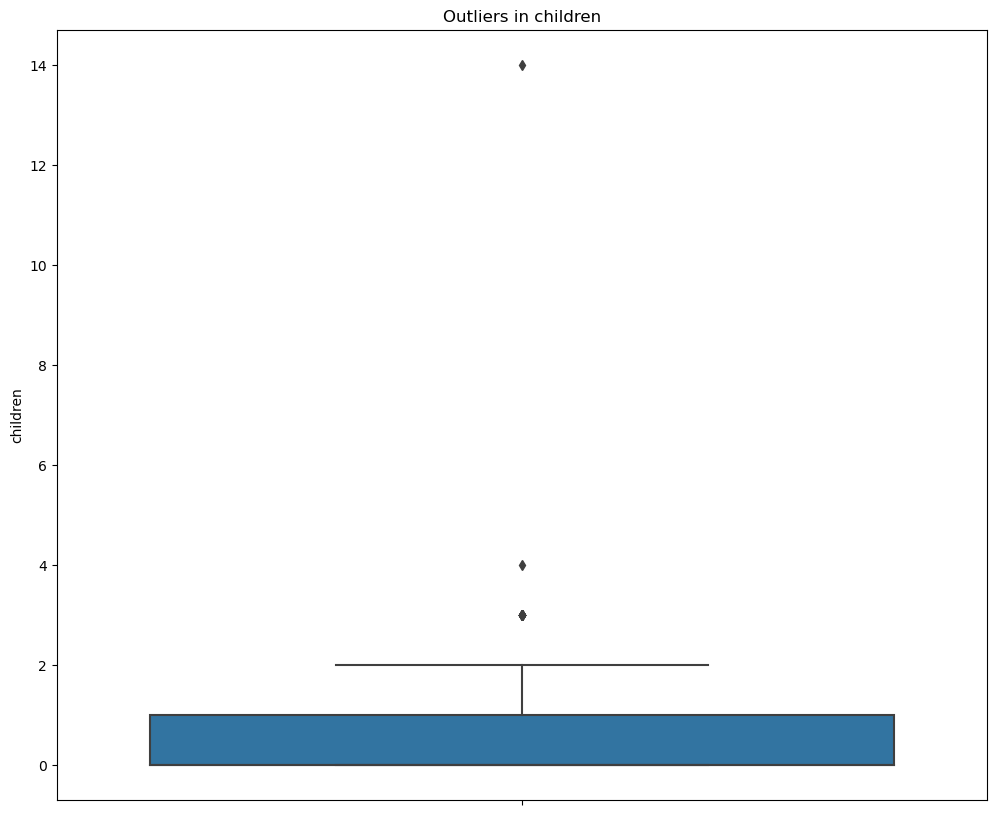

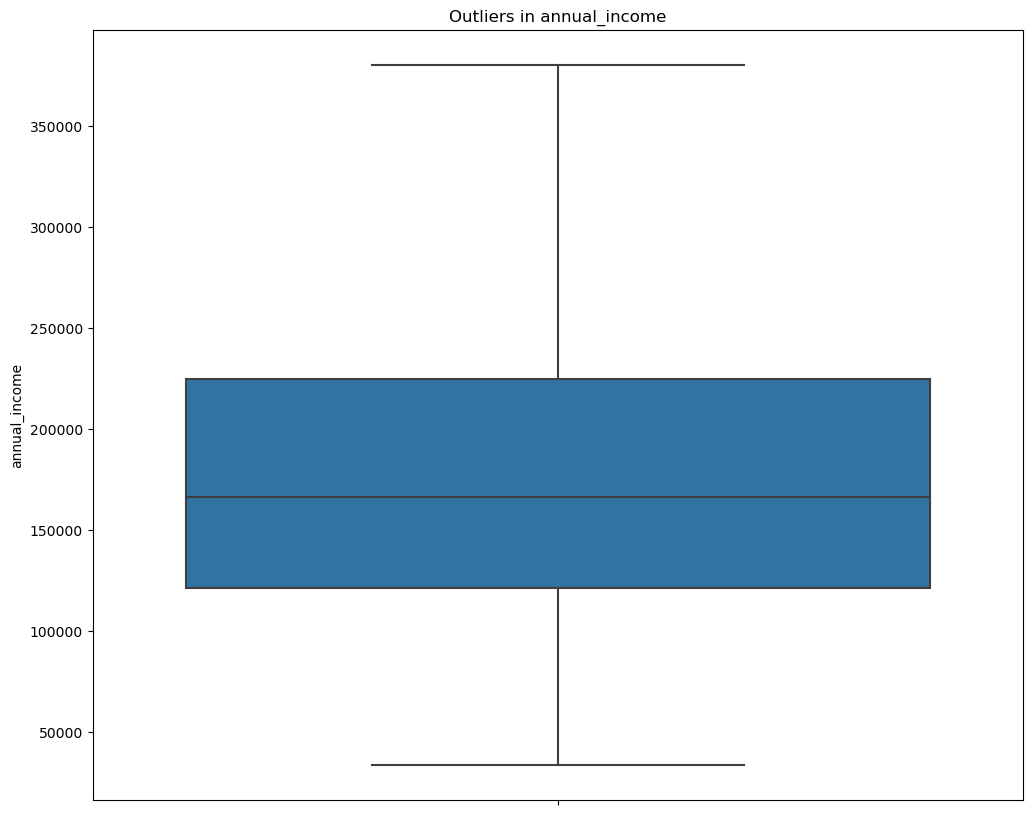

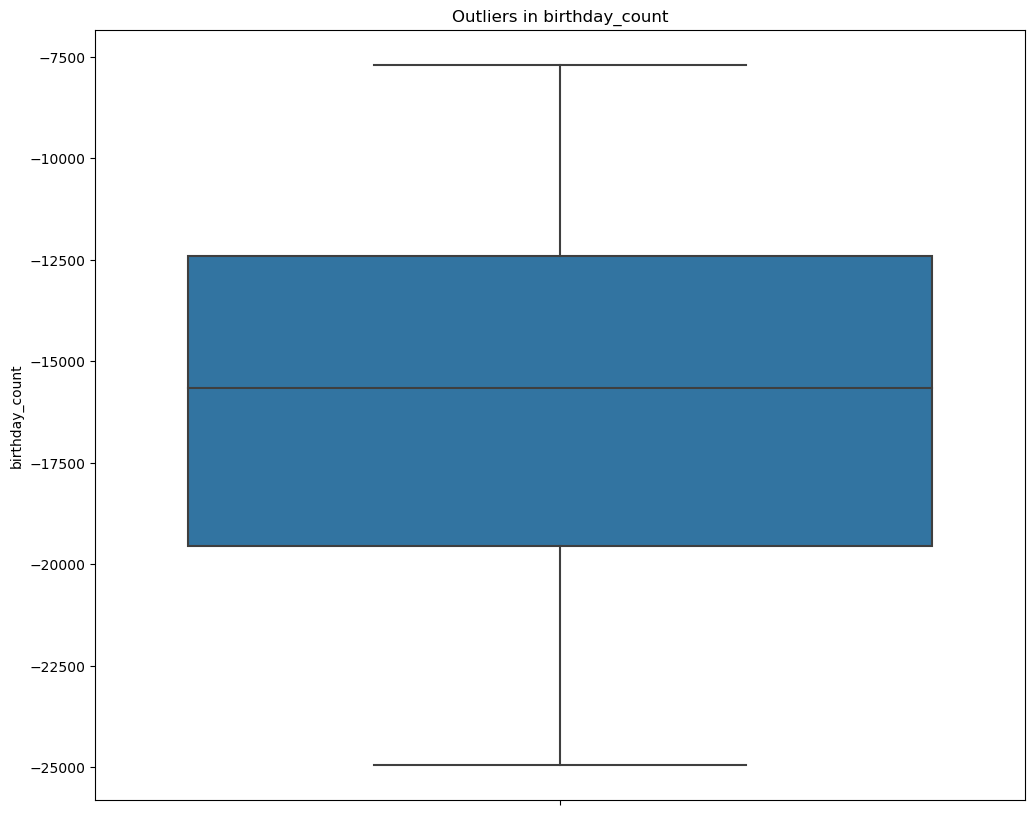

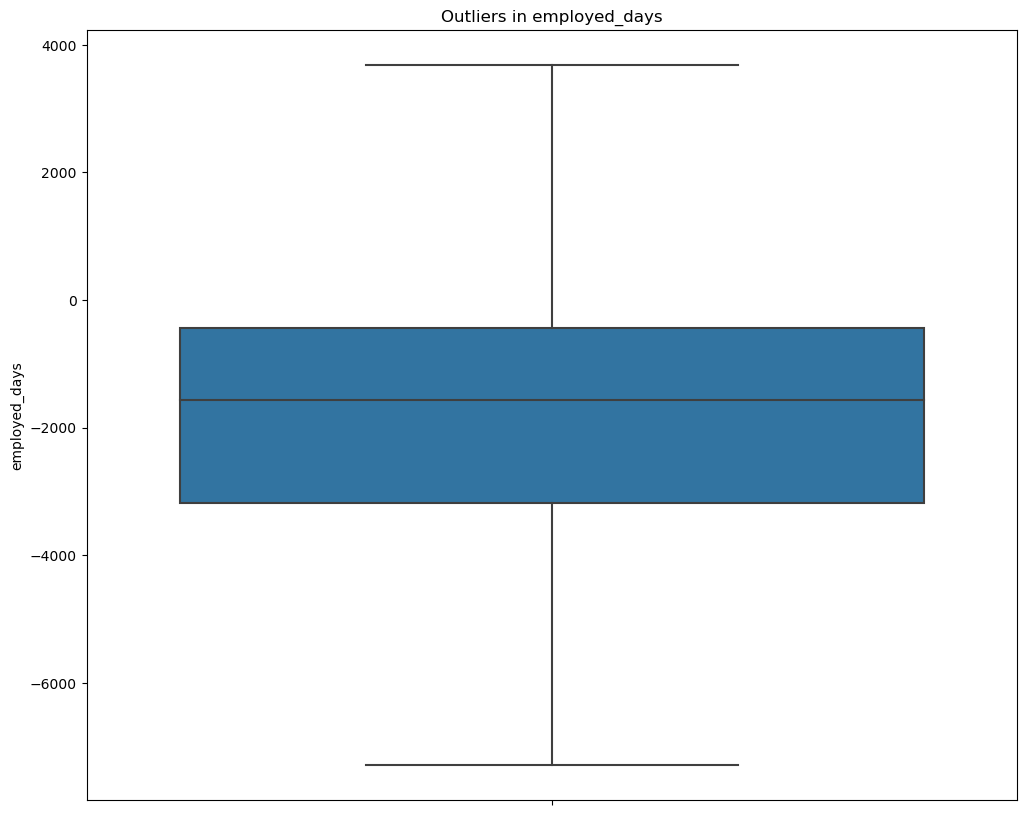

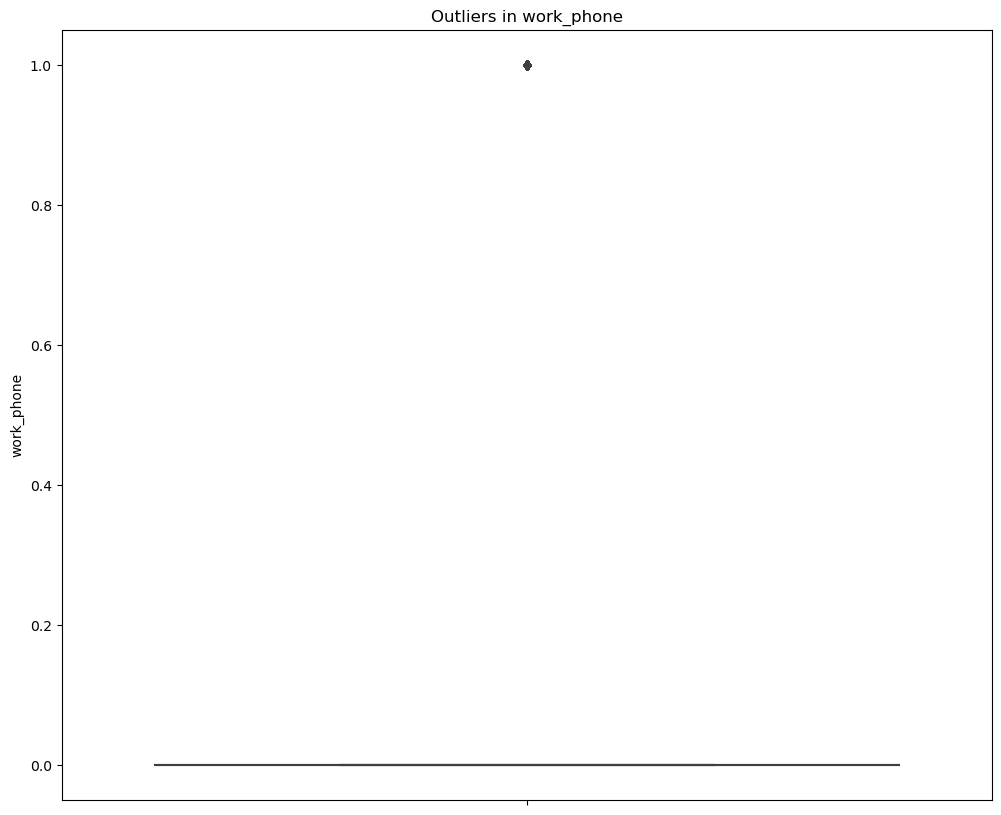

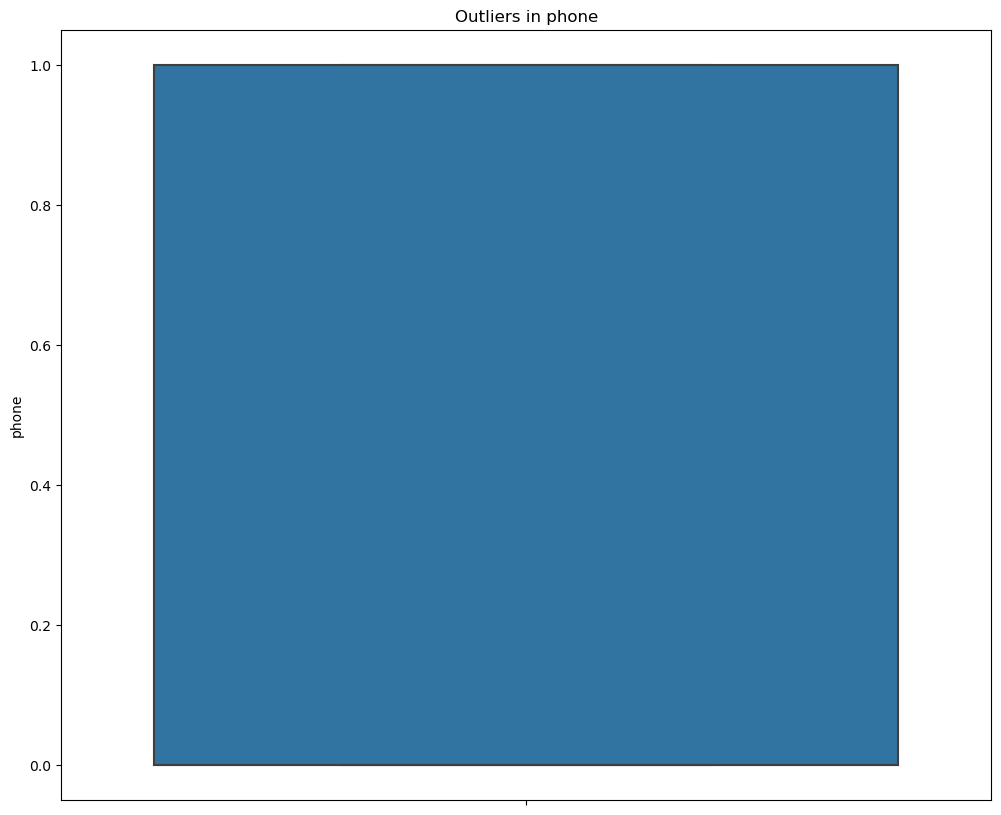

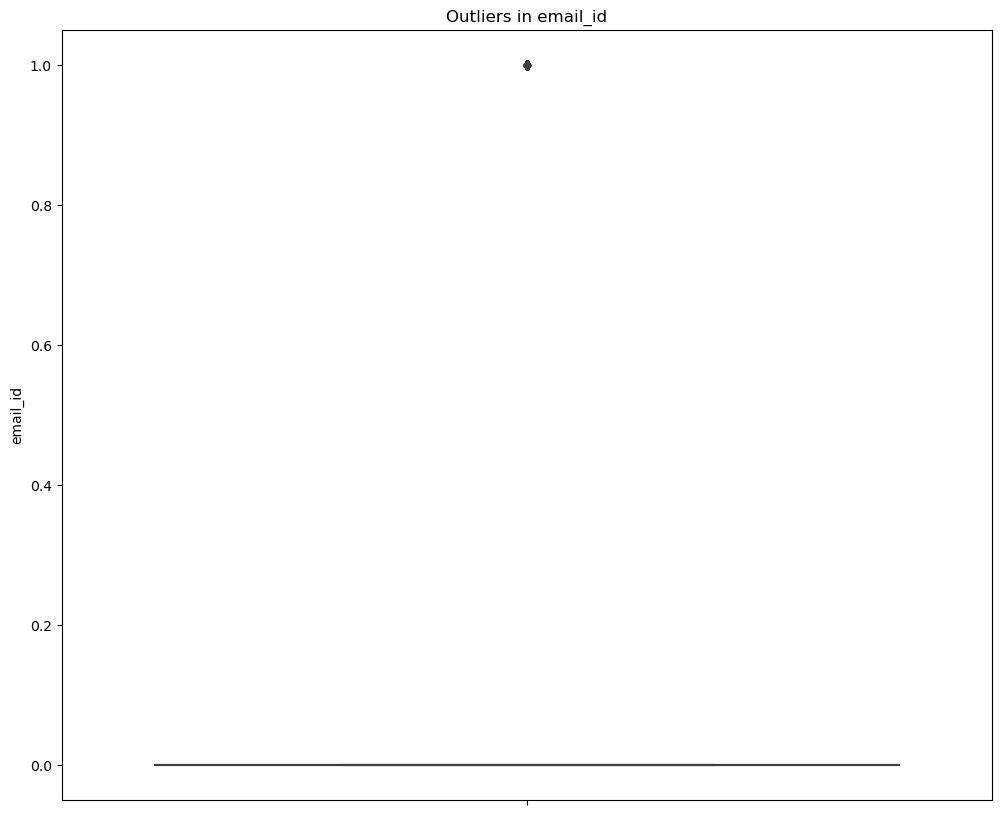

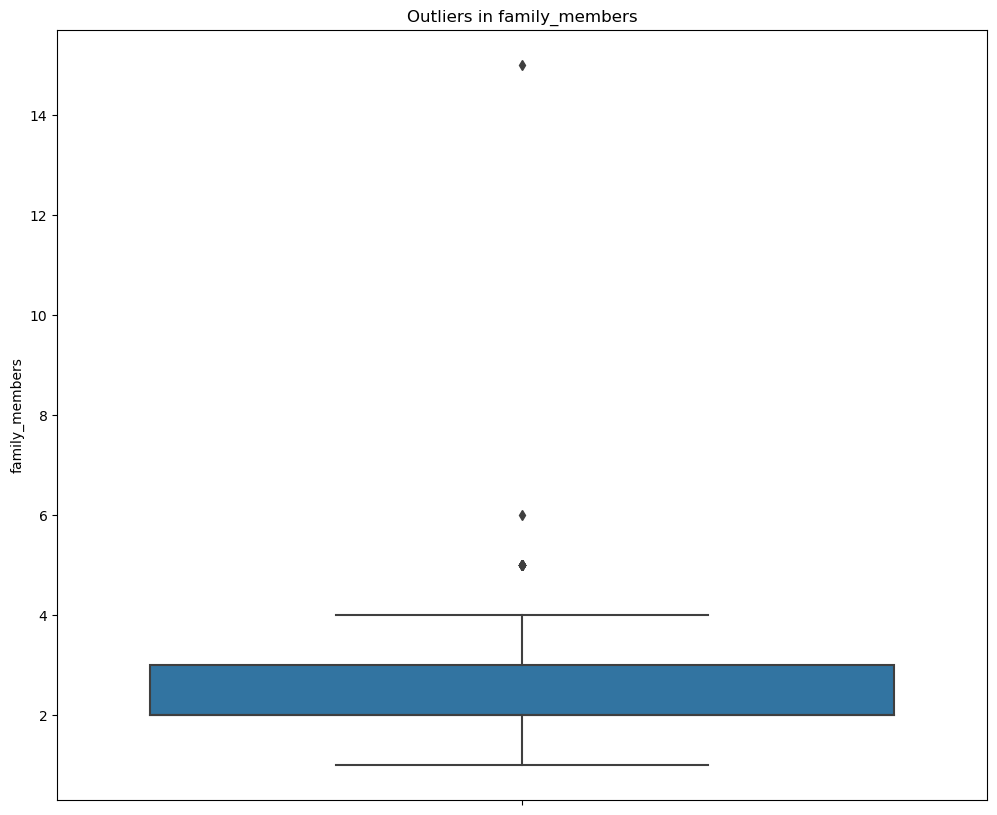

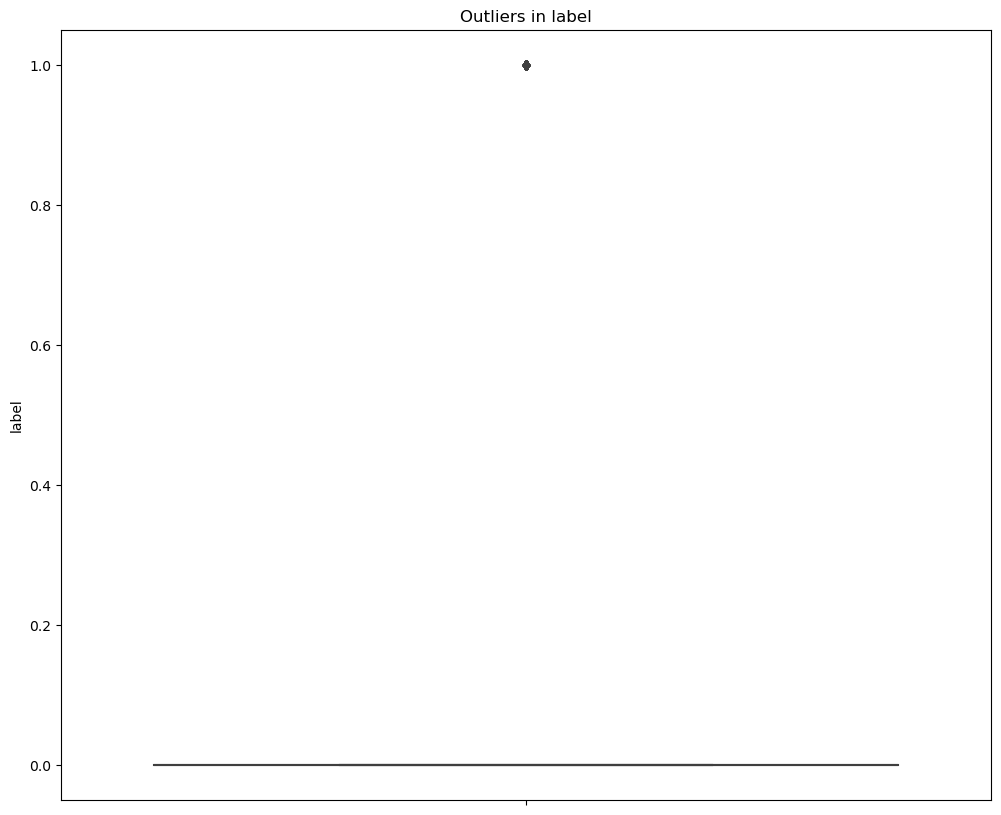

In [15]:
check_outliers(df)

## Filling missing values

In [16]:
df.groupby('gender')['annual_income'].agg(['mean', 'median'])

,mean,median
gender,,
F,166799.867049,153000.0
M,213212.254025,202500.0


In [17]:
def fill_income(string):
    if pd.isnull(string['annual_income']):
        if string['gender'] == 'F':
            return 153000.0
        return 202500.0
    return string['annual_income']

In [18]:
df['annual_income'] = df.apply(fill_income, axis=1)

In [19]:
df['gender'].fillna('F', inplace=True)

In [20]:
df['gender'] = df['gender'].apply(lambda x: 1 if x=='M'  else 0)

In [21]:
df['car_owner'] = df['car_owner'].apply(lambda x: 1 if x=='Y'  else 0)

In [22]:
df['propert_owner']= df['propert_owner'].apply(lambda x: 1 if x=='Y'  else 0)

In [23]:
df['birthday_count'].fillna(df['birthday_count'].median(), inplace=True)

In [24]:
df['type_occupation'] = df['type_occupation'].replace({np.nan:'unknown'})

<AxesSubplot:>

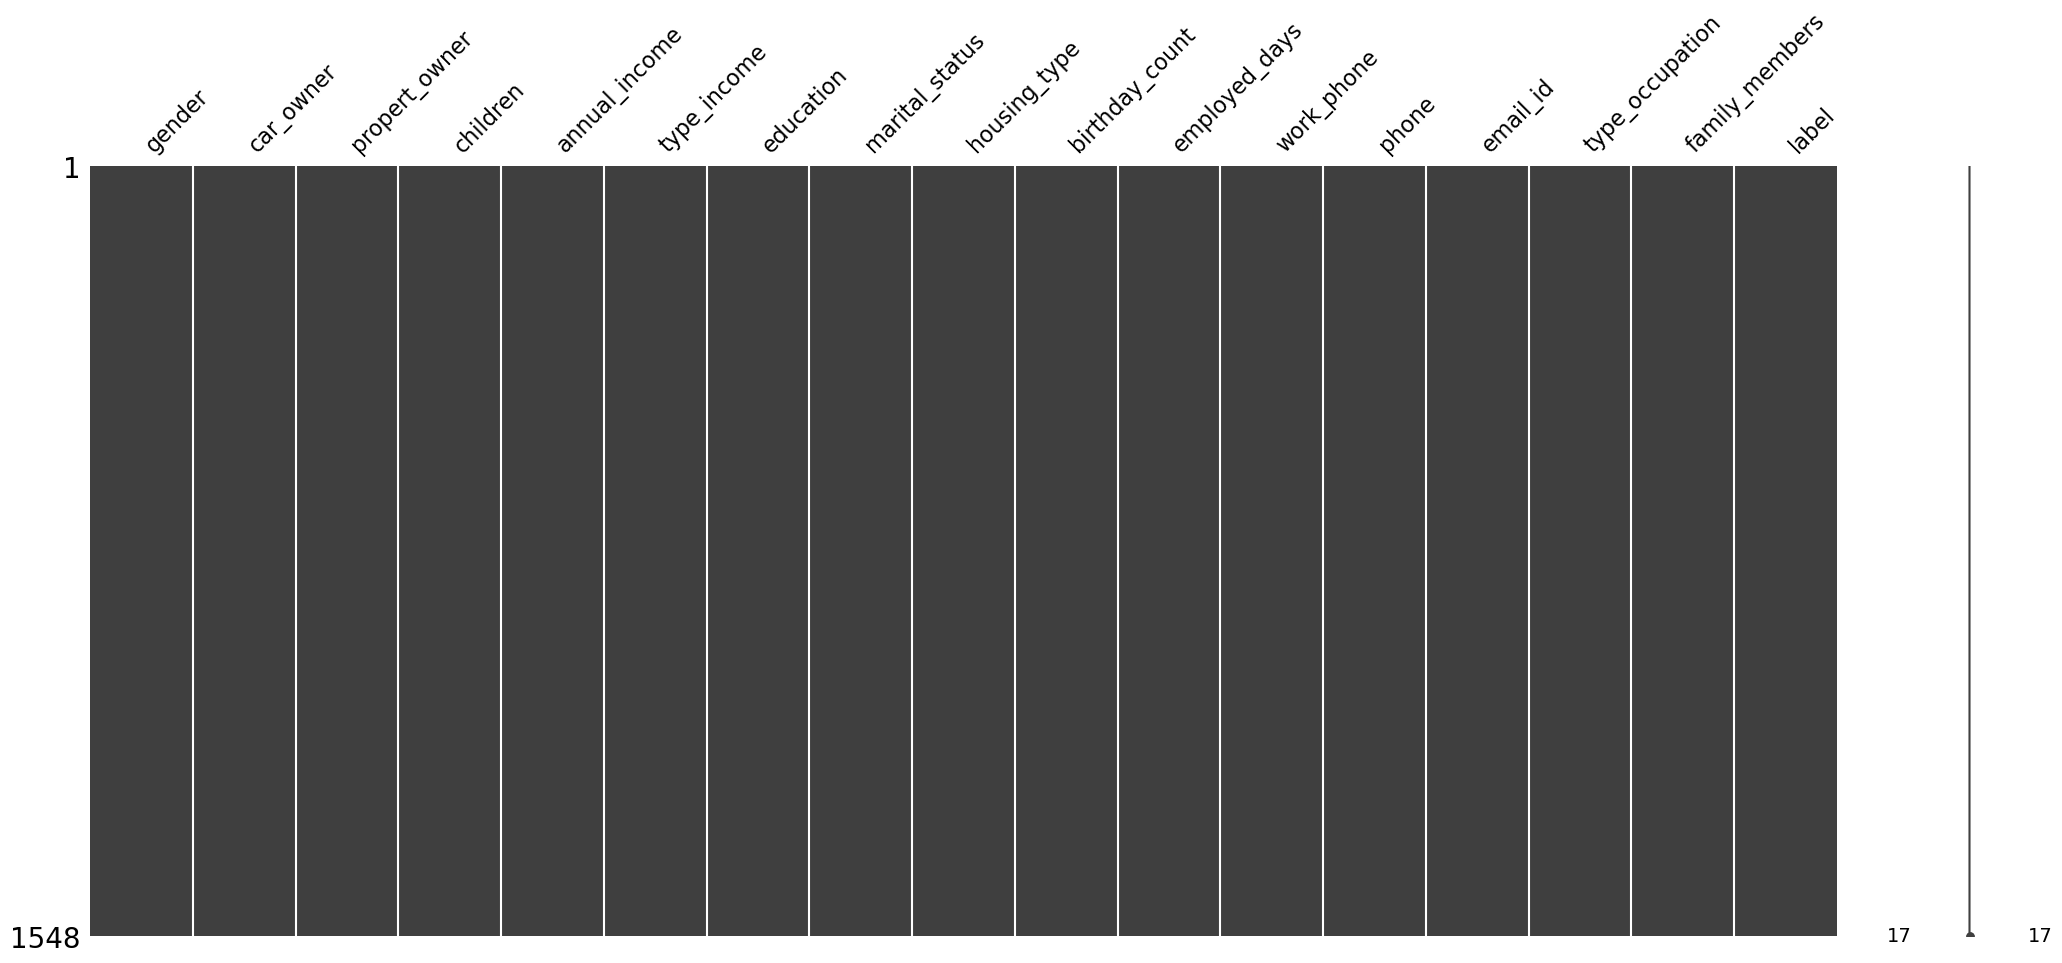

In [25]:
msn.matrix(df)

## Encoding data

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 1547
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           1548 non-null   int64  
 1   car_owner        1548 non-null   int64  
 2   propert_owner    1548 non-null   int64  
 3   children         1548 non-null   int64  
 4   annual_income    1548 non-null   float64
 5   type_income      1548 non-null   object 
 6   education        1548 non-null   object 
 7   marital_status   1548 non-null   object 
 8   housing_type     1548 non-null   object 
 9   birthday_count   1548 non-null   float64
 10  employed_days    1548 non-null   float64
 11  work_phone       1548 non-null   int64  
 12  phone            1548 non-null   int64  
 13  email_id         1548 non-null   int64  
 14  type_occupation  1548 non-null   object 
 15  family_members   1548 non-null   int64  
 16  label            1548 non-null   int64  
dtypes: float64(3),

In [27]:
df.loc[df['children'] != 0, 'children'] = 1

In [28]:
df.children.value_counts()

0    1091
1     457
Name: children, dtype: int64

In [29]:
[col for col in df.columns if df[col].dtype == np.object]

C:\Users\DELL\AppData\Local\Temp\ipykernel_19816\453769605.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [col for col in df.columns if df[col].dtype == np.object]


['type_income',
 'education',
 'marital_status',
 'housing_type',
 'type_occupation']

In [30]:
df['marital_status'].value_counts(normalize=True)

Married                 0.677649
Single / not married    0.146641
Civil marriage          0.065245
Separated               0.062016
Widow                   0.048450
Name: marital_status, dtype: float64

In [31]:
df.loc[~((df['marital_status'] == 'Married') | (df['marital_status'] == 'Single / not married')), 'marital_status'] = 'Other'

In [32]:
df['housing_type'].value_counts(normalize=True)

House / apartment      0.891473
With parents           0.051680
Municipal apartment    0.034238
Rented apartment       0.013566
Office apartment       0.005814
Co-op apartment        0.003230
Name: housing_type, dtype: float64

In [33]:
df.loc[~(df['housing_type'] == 'House / apartment'), 'housing_type'] = 'Other'

In [34]:
df['type_occupation'].value_counts(normalize=True)

unknown                  0.315245
Laborers                 0.173127
Core staff               0.112403
Managers                 0.087855
Sales staff              0.078811
Drivers                  0.055556
High skill tech staff    0.041990
Medicine staff           0.032300
Accountants              0.028424
Security staff           0.016150
Cleaning staff           0.014212
Cooking staff            0.013566
Private service staff    0.010982
Low-skill Laborers       0.005814
Secretaries              0.005814
Waiters/barmen staff     0.003230
HR staff                 0.001938
IT staff                 0.001292
Realty agents            0.001292
Name: type_occupation, dtype: float64

In [35]:
df.loc[~((df['type_occupation'] == 'unknown') | (df['type_occupation'] == 'Laborers') | (df['type_occupation'] == 'Core staff')),
      'type_occupation'] = 'Other'

In [36]:
df['family_members'].value_counts(normalize=True)

2     0.518088
1     0.215762
3     0.173127
4     0.082041
5     0.009690
6     0.000646
15    0.000646
Name: family_members, dtype: float64

In [37]:
df.loc[~((df['family_members'] == 1) | (df['family_members'] == 2) |(df['family_members'] == 3)), 'family_members'] = 'More'

In [38]:
df['education'].value_counts()

Secondary / secondary special    1031
Higher education                  426
Incomplete higher                  68
Lower secondary                    21
Academic degree                     2
Name: education, dtype: int64

In [39]:
def convert_education(education):
    if education == 'Lower secondary':
        return 1
    elif education == 'Secondary / secondary special':
        return 2
    elif education == 'Incomplete higher':
        return 3
    elif education == 'Higher education':
        return 4
    return 5

In [40]:
df['education'] = df['education'].apply(convert_education)

In [41]:
X = df.drop('label', axis=1)

In [42]:
y = df[['label']]

In [43]:
def encoding(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype == '0' and dataframe[col].nunique() == 2:
            le = LabelEncoder()
            dataframe[col] = le.fit_transform(dataframe[col])
    return pd.get_dummies(dataframe, drop_first = True, dtype = np.int64)

In [44]:
X = encoding(X)

In [45]:
sc = StandardScaler()

In [46]:
X_scaled = sc.fit_transform(X)

### The target feature ('label') has imbalance problem. 
### Resampling Methods:

### Oversampling: Increase the number of instances in the minority class. You can use techniques like Random Oversampling, Synthetic Minority Over-sampling Technique (SMOTE), or Adaptive Synthetic Sampling (ADASYN).

### Undersampling: Decrease the number of instances in the majority class. This can be done using techniques like Random Undersampling or Tomek Links.

In [47]:
oversampler = RandomOverSampler(random_state=42)
y = y.astype('int')

In [48]:
X, y = oversampler.fit_resample(X_scaled, y)
Counter(y)

Counter({'label': 1})

## Machine learning

In [51]:
def classif_models(X, y):
    np.random.seed(42)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    model_names = []
    accuracy, precision, recall, f1 = [], [], [], []
    
    classifiers = [('LogisticRegression', LogisticRegression()),
                   ('RandomForest', RandomForestClassifier())]
    for model in classifiers:
        model_names.append(model[0])
        cv_results = cross_validate(model[1], X, y, scoring = scoring, cv=5)
        print("Accuracy:", cv_results['test_accuracy'].mean())
        print("Precision:", cv_results['test_precision'].mean())
        print("Recall:", cv_results['test_recall'].mean())
        print("F1-Score:", cv_results['test_f1'].mean())
        
        accuracy.append(cv_results['test_accuracy'].mean())
        precision.append(cv_results['test_precision'].mean())
        recall.append(cv_results['test_recall'].mean())
        f1.append(cv_results['test_f1'].mean())
        
        data = pd.DataFrame({
        'Model name':model_names, 
        'Accuracy':accuracy, 
        'Precision':precision, 
        'Recall':recall,
        'F1 Score':f1
        })
    
    return data

In [52]:
scores = classif_models(X, y)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

Accuracy: 0.5917774465971188
Precision: 0.5893982824552508
Recall: 0.6023278035832781
F1-Score: 0.5956737805909297


C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

Accuracy: 0.991258155323729
Precision: 0.9828962430009505
Recall: 1.0
F1-Score: 0.9913549952379883


In [53]:
scores

,Model name,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.591777,0.589398,0.602328,0.595674
1,RandomForest,0.991258,0.982896,1.000000,0.991355
